In [12]:
import networkx as nx
import pandas as pd
import csv        
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
out_file = "Results/metrics.txt"
out_folder = "Results/"
file_out = open(out_file, "w")
important_nodes = ['0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', '0x8e6cd950ad6ba651f6dd608dc70e5886b1aa6b24', '0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xc944e90c64b2c07662a292be6244bdf05cda44a7', '0xdac17f958d2ee523a2206206994597c13d831ec7', '0x15874d65e649880c2614e7a480cb7c9a55787ff6', '0x249e38ea4102d0cf8264d3701f1a0e39c4f2dc3b', '0x1ceb5cb57c4d4e2b2433641b95dd330a33185a44', '0x0ae055097c6d159879521c384f1d2123d1f195e6', '0xab167e816e4d76089119900e941befdfa37d6b32', '0xf4d2888d29d722226fafa5d9b24f9164c092421e', '0x8b3192f5eebd8579568a2ed41e6feb402f93f73f', '0x6b3595068778dd592e39a122f4f5a5cf09c90fe2', '0xf65b5c5104c4fafd4b709d9d60a185eae063276c', '0xe53ec727dbdeb9e2d5456c3be40cff031ab40a55', '0xc40af1e4fecfa05ce6bab79dcd8b373d2e436c4e', '0xa47c8bf37f92abed4a126bda807a7b7498661acd', '0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce', '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', '0x00a8b738e453ffd858a7edf03bccfe20412f0eb0', '0xfca59cd816ab1ead66534d82bc21e7515ce441cf', '0x8762db106b2c2a0bccb3a80d1ed41273552616e8', '0x990f341946a3fdb507ae7e52d17851b87168017c', '0xd46ba6d942050d489dbd938a2c909a5d5039a161', '0xa2b4c0af19cc16a6cfacce81f192b024d625817d', '0x6b175474e89094c44da98b954eedeac495271d0f', '0xaaaebe6fe48e54f431b0c390cfaf0b017d09d42d', '0x514910771af9ca656af840dff83e8264ecf986ca', '0xd2dda223b2617cb616c1580db421e4cfae6a8a85', '0x2b591e99afe9f32eaa6214f7b7629768c40eeb39', '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0x389999216860ab8e0175387a0c90e5c52522c945', '0x3301ee63fb29f863f2333bd4466acb46cd8323e6', '0x3845badade8e6dff049820680d1f14bd3903a5d0', '0xbbc2ae13b23d715c30720f079fcd9b4a74093505', '0xc00e94cb662c3520282e6f5717214004a7f26888', '0x761d38e5ddf6ccf6cf7c55759d5210750b5d60f3', '0xcc4304a31d09258b0029ea7fe63d032f52e44efe', '0x27c70cd1946795b66be9d954418546998b546634', '0xd533a949740bb3306d119cc777fa900ba034cd52', '0x0b38210ea11411557c13457d4da7dc6ea731b88a', '0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e', '0x111111111117dc0aa78b770fa6a738034120c302', '0xfad45e47083e4607302aa43c65fb3106f1cd7607', '0x83e6f1e41cdd28eaceb20cb649155049fac3d5aa', '0x62359ed7505efc61ff1d56fef82158ccaffa23d7', '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0', '0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f']

In [14]:
MULTI_GRAPH_UNI = "../PoolsLiquidities/LiquidityPoolsWithinTime/UniSwapV2.csv"
MULTI_GRAPH_SUSHI = "../PoolsLiquidities/LiquidityPoolsWithinTime/SushiSwap.csv"
NUM_BLOCKS = 100
FIRST_BLOCK = 10060850
LAST_BLOCK = 15076596

<h1><span style="color:red">MultiGraphs</span></h1>
<p>These class consist of some weighted graphs.

In [48]:
class MultiGraphs:
    
    def __init__(self, file_path, dex_name, num_blocks):
        self.df_pools = pd.read_csv(file_path)
        self.dex_name = dex_name
        self.graphs = []
        for i in tqdm(range(0, num_blocks)):
            str_now = "count" + str(i)
            graph_new = WeightedDexGraph(self.df_pools, dex_name, str_now)
            self.graphs.append(graph_new)
    
    def get_centralities(self, node_address):
        cnt = 0
        ans = []
        cnt = 0
        for graph in tqdm(self.graphs):
            cnt = cnt + 1
            vec_ans = graph.get_eigen_centrality()
            if(not node_address in vec_ans):
                ans.append(0)
            else:
                ans.append(vec_ans[node_address])
#             print(cnt, vec_ans[node_address])
        return ans
    
    def draw_centralities(self, node_address, node_name, address_input):
        
        plt.gca().cla()

        y = self.get_centralities(node_address)
        
        dis = (LAST_BLOCK - FIRST_BLOCK) / 100
        
        x = []
        now = FIRST_BLOCK
        for i in range(0,NUM_BLOCKS):
            x.append(now)
            now += dis
            
#         node_name = self.graphs[0].get_node_name(node_address)
        
        plt.plot(x, y)
        plt.ylabel(f"{node_name} Token Centrality")
        plt.xlabel("Block Number")
#         plt.title(f" {node_name} Centrality in {self.dex_name}")
        plt.savefig(address_input + f'{node_name}-centrality-{self.dex_name}.png')
    
        plt.show
        
    def draw_centralities_specific(self, node_address, node_name, address_input):
        
#         plt.gca().cla()

        y = self.get_centralities(node_address)
        
        dis = (LAST_BLOCK - FIRST_BLOCK) / 100
        
        x = []
        now = FIRST_BLOCK
        for i in range(0,NUM_BLOCKS):
            x.append(now)
            now += dis
            
#         node_name = self.graphs[0].get_node_name(node_address)
        sum_all = sum(y)
        y_without_zero = [temp for temp in y if temp != 0]
        num = len(y_without_zero)
        avg = sum_all / num
        var = np.var(y_without_zero)
        y = [temp / avg for temp in y]
        
        plt.plot(x, y, label = self.dex_name)
        plt.ylabel(f" Normalized {node_name} Token Centrality")
        plt.xlabel("Block Number")
#         plt.title(f"Normalized {node_name} Token Centrality Over Time")
  
        plt.show
 
    def get_node_address(token_name):
        
        y = self.get_centralities(node_address)
        
 
        

<h1><span style="color:red">DexPools</span></h1>
<p>Each of these classes represent a pool in either Uniswap or SushiSwap.<p>

In [16]:
class DexPools:
    
    def __init__(self, file_path, dex_name):
        
        self.df_pools = pd.read_csv(file_path)
        self.name = dex_name
    
    def filter_first_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.FirstBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.FirstBlock <= block_last]
        return df_pools_out
    
    def filter_last_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.LastBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.LastBlock <= block_last]
        return df_pools_out
    
    def filter_count(self, pools_inp, cnt_min, cnt_max):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"CntTransfer":"int"})
        df_pools_out = df_pools_out[df_pools_out.CntTransfer >= cnt_min]
        df_pools_out = df_pools_out[df_pools_out.CntTransfer <= cnt_max]
        return df_pools_out
    
    def find_lost_pools(self):
        df_pools_out = self.filter_count(self.df_pools, 100000, 10000000000)
        df_pools_out = self.filter_last_blocks(df_pools_out, 0, 14500000)
        return df_pools_out
    
    def get_edge_cnt(self, token1, token2):
        df_pools = self.df_pools[self.df_pools.AddressToken0 == token1]
        df_pools = df_pools[df_pools.AddressToken1 == token2]
        if(len(df_pools) == 0):
            return None
        else:
            return df_pools.iloc[0]['CntTransfer']

<h1><span style="color:red">WeightedDexGraph</span></h1>
<p>These classes are used for keeping graphs made within a time between various token in a specific platform.<p>

In [17]:
COLUMN_NAME = ["AddressToken0","AddressToken1"]

class WeightedDexGraph:

    def __init__(self, df_pools, name, cnt_transfer = "CntTransfer"):
        
        self.crypto_graph = nx.Graph()
        self.name = name
        
        nodes = pd.DataFrame({'Id': [], 'Label': []})
        edges = pd.DataFrame({'Source': [], 'Target': [], 'Weight': []})
        
        dict_ind = {}
        symbol = []
        cnt_nodes_seen = 1
        
        nx.set_node_attributes(self.crypto_graph, symbol, "symbol")

        for row in df_pools.index:
                
            sell_token = df_pools['AddressToken0'][row]
            buy_token = df_pools['AddressToken1'][row]
            
            count_transfer = df_pools[cnt_transfer][row]
            
            
            if(count_transfer == 0):
                continue
            
            self.add_node(self.crypto_graph, buy_token)
            self.add_node(self.crypto_graph, sell_token)
            
            sell_symbol = df_pools['SymbolToken0'][row]
            buy_symbol = df_pools['SymbolToken1'][row]
                        
            self.crypto_graph.nodes[sell_token]["symbol"] = sell_symbol
            self.crypto_graph.nodes[buy_token]["symbol"] = buy_symbol
            
            
            if(not buy_token in dict_ind):
                dict_ind[buy_token] = cnt_nodes_seen
                nodes = pd.concat([nodes, pd.DataFrame([{'Id': buy_token, 'Label': buy_symbol}])], ignore_index=True)

                cnt_nodes_seen += 1
            
            if(not sell_token in dict_ind):
                dict_ind[sell_token] = cnt_nodes_seen
                nodes = pd.concat([nodes, pd.DataFrame([{'Id': sell_token, 'Label': sell_symbol}])], ignore_index=True)
                cnt_nodes_seen += 1
            
            if(not(self.crypto_graph.has_edge(buy_token, sell_token)) and count_transfer != 0):
                self.crypto_graph.add_edge(buy_token, sell_token, weight = count_transfer)
                edges = pd.concat([edges, pd.DataFrame([{'Source':buy_token, 'Target': sell_token, 
                              'Weight': count_transfer}])], ignore_index=True)
        self.build_file_graph(nodes, edges, name)
    
    def build_file_graph(self, nodes, edges, name):
        nodes.to_csv('Graph-For-Gephi/' + name + 'nodes' + '.csv', index=False, float_format='%g')
        edges.to_csv('Graph-For-Gephi/' + name + 'edges' + '.csv', index=False, float_format='%g')
                
    def get_node_name(self, node_address):
         return self.crypto_graph.nodes[node_address]["symbol"]
                
    def get_eigen_centrality(self):
        if(len(self.crypto_graph) == 0):
            return []
        eigen_centrality = nx.eigenvector_centrality(self.crypto_graph,weight = 'weight', max_iter = 100000, 
                                                     tol = 1e-4) 
        return eigen_centrality
    
    def get_reversed_sorted_ranks(self, dict_ranks):
        
        dict_ans = dict(sorted(dict_ranks.items(), key = lambda x:-1 * x[1]))
        return dict_ans
    
    def change_ranks_with_symbol(self, dict_ranks):
        
        dict_ans = [(self.crypto_graph.nodes[key]["symbol"], value) 
                        for (key, value) in dict_ranks.items()]
        return dict_ans
    
    def get_top_ranks(self, rank_inp, number_of_tokens):
        return rank_inp[0:number_of_tokens - 1]
        
    def get_page_rank(self):
        
        page_rank = nx.pagerank(self.crypto_graph,weight = 'weight', max_iter = 1000, alpha=0.9, 
                               tol = 1e-4)
        return page_rank
    
    
    
    def get_degree(self, node_name):
        if(not self.crypto_graph.has_node(node_name)):
            return 0
        return self.crypto_graph.degree[node_name]

    def add_node(self, graph_input, token_input):
        if(not graph_input.has_node(token_input)):
            graph_input.add_node(token_input)
    
    def get_list_degree(self):
        degree_node_list = self.crypto_graph.degree()
        degree_list = [deg[1] for deg in degree_node_list]
        degree_list.sort()
        return degree_list

    def print(self, file_path_output):
        graph_file = open(file_path_output, 'w')
        graph_writer = csv.writer(graph_file)
        graph_writer.writerow(COLUMN_NAME)
        for edge in self.crypto_graph.edges:
             graph_writer.writerow(edge)

    def get_best_vertices(self, num):
        degree_node_list = self.crypto_graph.degree()
        degree_node = sorted(degree_node_list, key = lambda vertex: vertex[1])    
        return degree_node
    
    def get_count_deg(self, degree_list):
        count_deg = [(num, degree_list.count(num)) for num in degree_list]
        count_deg = [*set(count_deg)]
        count_deg = sorted(count_deg, key = lambda x: x[0])
        return count_deg
    
    def draw_plot_degree(self, degree_list, flag = False):
        
        count_deg = self.get_count_deg(degree_list)
        
        x = np.array([tmp[1] for tmp in count_deg])
        y = -0.8435 * x + 4.6
        print(x, y)

        plt.xscale('log')
        plt.yscale('log')
        plt.plot([tmp[1] for tmp in count_deg], [tmp[0] for tmp in count_deg])
        if(flag):
            plt.xlabel("Log Count Nodes")
            plt.ylabel("Log Degree")
            plt.show()
 
        plt.plot(x, y)
        plt.ylabel("Log Count Nodes")
        plt.xlabel("Log Degree")
        plt.title(f"{self.name} Log Log plot")
        
        plt.show()
    
    def print_info(self, is_avg_clustering = True, is_plot = True, is_page_rank = True,
            is_betweeness = False, is_eigen = False, is_closeness = False):
        
        print(f"Number of Nodes {self.name} is: ", self.crypto_graph.number_of_nodes())
        print(f"Number of Edges {self.name} is: ", self.crypto_graph.number_of_edges())
        print(f"Average Degree {self.name} is: ", (self.crypto_graph.number_of_edges() * 2) 
      / self.crypto_graph.number_of_nodes())
        if(is_avg_clustering):
            print(f"Average Clustering {self.name} is: ", nx.average_clustering(uni_graph.crypto_swaps_graph))
        if(is_plot):
            degree_list_graph = self.get_list_degree()
            self.draw_plot_degree(degree_list_graph)
            
        if(is_page_rank):    
            page_rank = self.get_sorted_page_rank_nodes()
            print(f"{self.name} Top 100 Tokens: ", page_rank[-1:-100:-1])
        
        if(is_betweeness):
            betweenness_centrality = nx.betweenness_centrality(dex_graph.crypto_swaps_graph)
            betweenness_centrality = sorted(betweenness_centrality.items(), key = operator.itemgetter(1))    
            print("Betweenness", betweenness_centrality)
            
        if(is_eigen):
            eigen_vector_centrality = nx.eigenvector_centrality(dex_graph.crypto_swaps_graph)
            print("EigenVector", eigen_vector_centrality)
        
        if(is_closeness):
            closeness_centrality = nx.closeness_centrality(dex_graph.crypto_swaps_graph)
            closeness_centrality = sorted(closeness_centrality.items(), key = operator.itemgetter(1))    
            print("Closeness", closeness_centrality)
            
        print("Components:")
        num_componenent = [x for x in nx.connected_components(self.crypto_graph)]
        print([len(component) for component in num_componenent])
        
        
        num_nodes = self.crypto_graph.number_of_nodes()
        max_edges = (num_nodes * (num_nodes - 1)) / 2
        print("Density of the graph is: ", (self.crypto_graph.number_of_edges() * 2) / (max_edges))
        
    def check_power_law(self):
            
        count_deg = self.get_count_deg(self.get_list_degree())

        x = [np.log(sample[0]) for sample in count_deg]
        y = [np.log(sample[1]) for sample in count_deg]
        x2 = sm.add_constant(x)
        est = sm.OLS(y, x2)
        print(est.fit().summary())
        print(est.fit().f_pvalue)
    
    def plot_degree(self, degree_list):
        
        x_axis = [a[0] for a in degree_list]
        y_axis = [a[1] for a in degree_list]
        plt.plot(x_axis, y_axis)
        plt.ylabel("Count Nodes")
        plt.xlabel("Degree")
        plt.title(f"{self.name} Degree Distribution Plot")
        
        plt.show()
    
    def plot_log_degree(self, degree_list):
        eps = 1e-7
        x_axis = [np.log(a[0] + eps) for a in degree_list]
        y_axis = [np.log(a[1] + eps) for a in degree_list]
        plt.plot(x_axis, y_axis)
        plt.ylabel("Log Count Nodes")
        plt.xlabel("Log Degree")
        plt.title(f"{self.name} Log Degree Distribution Plot")
        
        plt.show()
    
        

In [18]:
   def get_block_range(index):
        dis = (LAST_BLOCK - FIRST_BLOCK) / 100
        ans = [dis * index + FIRST_BLOCK, dis * (index + 1) + FIRST_BLOCK]
        return ans

<h2><span style="color:red">Making Without Filter Dex Pools</span></h2>

In [19]:
uni_dex = DexPools("../PoolsLiquidities/LiquidityPools/UniSwapV2.csv", "UniSwapV2")
sushi_dex = DexPools("../PoolsLiquidities/LiquidityPools/SushiSwap.csv", "SushiSwap")

<h2><span style="color:red">Function for removing nodes without any edge in a network</span></h2>

In [20]:
def remove_nodes_deg0(G):
    edges_to_remove = [(u, v) for u, v, weight in G.edges(data='weight') if weight == 0]

    G.remove_edges_from(edges_to_remove)
    nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(nodes_to_remove)

<h2><span style="color:red">Making weighted networks</span></h2>

In [21]:
uni_graph = WeightedDexGraph(uni_dex.df_pools, "UniSwapV2")
sushi_graph = WeightedDexGraph(sushi_dex.df_pools, "SushiSwap")

In [24]:
remove_nodes_deg0(uni_graph.crypto_graph)
remove_nodes_deg0(sushi_graph.crypto_graph)

In [25]:
file_out.write("Uniswap weighted graph: "+ str(uni_graph.crypto_graph) + "\n")
file_out.write("SushiSwap weighted graph: "+ str(sushi_graph.crypto_graph) + "\n")

63

In [26]:
dex_type = ["Uniswap", "SushiSwap"]
for dex in dex_type:

    if(dex == "Uniswap"):
        dex_graph = uni_graph
    else:
        dex_graph = sushi_graph
    sz = [len(x) for x in nx.connected_components(dex_graph.crypto_graph)]
    file_comp = open(f"./Results/Components/Components-not-giant {dex}.txt", "w")
    file_comp.write(f"{dex} graph non-giant components' info:\n")
    file_comp.write(str(sz) + "\n")

    for x in nx.connected_components(dex_graph.crypto_graph):
        if(len(x) != max(sz)):
            cnt = 0
            for node_address in x:
                cnt += 1
                if(cnt != len(x)):
                    file_comp.write(dex_graph.crypto_graph.nodes[node_address]["symbol"] + ",")
                else:
                    file_comp.write(dex_graph.crypto_graph.nodes[node_address]["symbol"] + "\n")
    file_comp.close()

<h2><span style="color:red">Make uniswap and sushiswap graph files</span></h2>

In [27]:
nx.write_gexf(uni_graph.crypto_graph, "Uniswap.gexf")
nx.write_gexf(sushi_graph.crypto_graph, "Sushiswap.gexf")

In [28]:
nx.write_weighted_edgelist(sushi_graph.crypto_graph, "SushiWeighted.csv")

<h2><span style="color:red">Eigen Centrality for Graphs</span></h2>

In [29]:
dex_type = ["Uniswap", "SushiSwap"]
for dex in dex_type:

    if(dex == "Uniswap"):
        dex_graph = uni_graph
    else:
        dex_graph = sushi_graph
    file_dex = open(f"Results/Centrality/EigenTop50-{dex}.txt", "w")
    eigen_vec = dex_graph.get_eigen_centrality()
    eigen_vec = dex_graph.get_reversed_sorted_ranks(eigen_vec)
    eigen_vec = dex_graph.change_ranks_with_symbol(eigen_vec)
    top_ranks = dex_graph.get_top_ranks(eigen_vec, 50)
    file_dex.write(f"Top 50 token {dex}:\n")
    file_dex.write(str(top_ranks))
    file_dex.close()

<h2><span style="color:red">Page Rank Centrality for Graphs</span></h2>

In [30]:
dex_type = ["Uniswap", "SushiSwap"]
for dex in dex_type:

    if(dex == "Uniswap"):
        dex_graph = uni_graph
    else:
        dex_graph = sushi_graph
    file_dex = open(f"Results/Centrality/PageRankTop50-{dex}.txt", "w")
    pg_vec = dex_graph.get_page_rank()
    pg_vec = dex_graph.get_reversed_sorted_ranks(pg_vec)
    pg_vec = dex_graph.change_ranks_with_symbol(pg_vec)
    top_ranks = dex_graph.get_top_ranks(pg_vec, 50)
    file_dex.write(f"Top 50 token {dex}:\n")
    file_dex.write(str(top_ranks))
    file_dex.close()

<h2><span style="color:red">Degree With Weights Graphs</span></h2>

In [63]:
dex_type = ["Uniswap", "SushiSwap"]
for dex in dex_type:

    if(dex == "Uniswap"):
        dex_graph = uni_graph
    else:
        dex_graph = sushi_graph
    file_dex = open(f"Results/Centrality/DegTop50-{dex}.txt", "w")
    deg_vec = dict(dex_graph.crypto_graph.degree(weight = 'weight'))
    deg_vec = dex_graph.get_reversed_sorted_ranks(deg_vec)
    deg_vec = dex_graph.change_ranks_with_symbol(deg_vec)
    top_ranks = dex_graph.get_top_ranks(deg_vec, 50)
    file_dex.write(f"Top 50 token {dex}:\n")
    file_dex.write(str(top_ranks))
    file_dex.close()

<h2><span style="color:red">Graphs With Time Limit</span></h2>

In [31]:
uni_multi_graph = MultiGraphs(MULTI_GRAPH_UNI, "UniswapV2", NUM_BLOCKS)

100%|█████████████████████████████████████████| 100/100 [05:16<00:00,  3.17s/it]


In [49]:
sushi_multi_graph = MultiGraphs(MULTI_GRAPH_SUSHI, "SushiSwap", NUM_BLOCKS)

100%|█████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


100%|█████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


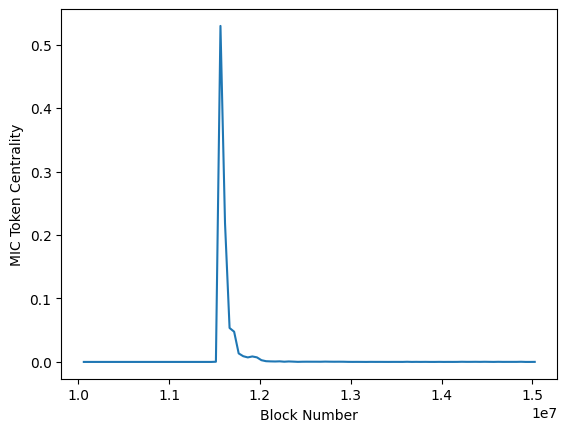

In [50]:
sushi_multi_graph.draw_centralities("0x368b3a58b5f49392e5c9e4c998cb0bb966752e51", "MIC","./Results/CentralitiesWithinTime/")


 25%|██████████▌                               | 25/100 [00:03<00:10,  6.86it/s]


KeyboardInterrupt: 

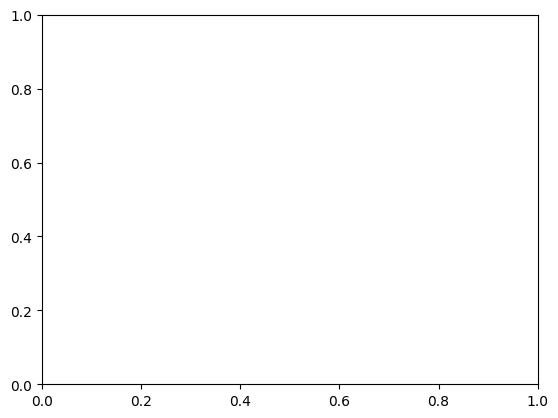

In [33]:
folder_address = "./Results/CentralitiesWithinTime/"
for node in important_nodes:
    if(node in sushi_graph.crypto_graph.nodes):
        sushi_multi_graph.draw_centralities(node, sushi_graph.crypto_graph.nodes[node]["symbol"], folder_address)
    if(node in uni_graph.crypto_graph.nodes):
        uni_multi_graph.draw_centralities(node, uni_graph.crypto_graph.nodes[node]["symbol"], folder_address)

In [ ]:
folder_address = "./Results/CentralitiesWithinTime/"
# should_be_checked = input()
symobl = ""
for node in important_nodes:
#     flag = False
    if(node in sushi_graph.crypto_graph.nodes):
#         if(sushi_graph.crypto_graph.nodes[node]["symbol"] == should_be_checked):
        sushi_multi_graph.draw_centralities_specific(node, sushi_graph.crypto_graph.nodes[node]["symbol"], file_address)
        symbol = sushi_graph.crypto_graph.nodes[node]["symbol"]
#             flag = True
    if(node in uni_graph.crypto_graph.nodes):
#         if(uni_graph.crypto_graph.nodes[node]["symbol"] == should_be_checked):
        uni_multi_graph.draw_centralities_specific(node, uni_graph.crypto_graph.nodes[node]["symbol"], file_address)
        symbol = uni_graph.crypto_graph.nodes[node]["symbol"]
#             flag = True
#     if(flag):
    file_address = f"./Results/CentralitiesWithinTime/{symbol} in Both DEXes.png"
    plt.legend()
    plt.savefig(file_address)
    plt.gca().cla()

<h2><span style="color:red">Wiered Graphs</span></h2>

In [45]:
sushi_wierd_graph = sushi_multi_graph.graphs[30]
eigen_vec = sushi_wierd_graph.get_eigen_centrality()
eigen_vec = sushi_wierd_graph.get_reversed_sorted_ranks(eigen_vec)
print(eigen_vec)
eigen_vec = sushi_wierd_graph.change_ranks_with_symbol(eigen_vec)
rank_sushi = sushi_wierd_graph.get_top_ranks(eigen_vec, 50)
print(rank_sushi)

{'0xdac17f958d2ee523a2206206994597c13d831ec7': 0.6820855705023369, '0x368b3a58b5f49392e5c9e4c998cb0bb966752e51': 0.5295140029309339, '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 0.3860912865639928, '0x4b4d2e899658fb59b1d518b68fe836b100ee8958': 0.2733676563868116, '0x6b3595068778dd592e39a122f4f5a5cf09c90fe2': 0.08642626542821508, '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 0.08407968596867757, '0x6b175474e89094c44da98b954eedeac495271d0f': 0.08027040324171807, '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599': 0.05471307774761669, '0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e': 0.040073663796813895, '0x514910771af9ca656af840dff83e8264ecf986ca': 0.027783134415966637, '0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f': 0.02562764080080982, '0xd533a949740bb3306d119cc777fa900ba034cd52': 0.024750764364478504, '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984': 0.02078168206063787, '0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9': 0.01966632138129478, '0xe0839f9b9688a77924208ad509e29952dc660261': 0.01743649293733

In [33]:
print(get_block_range(34))

[11766203.64, 11816361.1]


In [158]:
degree_list = dict(sushi_wierd_graph.crypto_graph.degree(weight = 'weight'))
degree_list = sushi_wierd_graph.get_reversed_sorted_ranks(degree_list)
degree_list = sushi_wierd_graph.change_ranks_with_symbol(degree_list)
sushi_wierd_graph.get_top_ranks(degree_list, 20)

[('WETH', 184464),
 ('USDT', 27651),
 ('COVER', 21576),
 ('USDC', 21042),
 ('SUSHI', 18035),
 ('DAI', 15740),
 ('YFI', 10720),
 ('SNX', 9986),
 ('WBTC', 9702),
 ('LINK', 8340),
 ('DSD', 4028),
 ('KP3R', 3524),
 ('UNI', 3199),
 ('UMA', 2968),
 ('AAVE', 2610),
 ('CRV', 2500),
 ('COMP', 2324),
 ('REN', 2268),
 ('sUSD', 1858)]

In [23]:
uni_wierd_graph = uni_multi_graph.graphs[33]
eigen_vec = uni_wierd_graph.get_eigen_centrality()
eigen_vec = uni_wierd_graph.get_reversed_sorted_ranks(eigen_vec)
print(list(eigen_vec)[0:20])
eigen_vec = uni_wierd_graph.change_ranks_with_symbol(eigen_vec)
uni_wierd_graph.get_top_ranks(eigen_vec, 50)

['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xdac17f958d2ee523a2206206994597c13d831ec7', '0x6b175474e89094c44da98b954eedeac495271d0f', '0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', '0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', '0x374cb8c27130e2c9e04f44303f3c8351b9de61c1', '0x1337def16f9b486faed0293eb623dc8395dfe46a', '0x8c8687fc965593dfb2f0b4eaefd55e9d8df348df', '0x3c03b4ec9477809072ff9cc9292c9b25d4a8e6c6', '0x3472a5a71965499acd81997a54bba8d852c6e53d', '0x220b71671b649c03714da9c621285943f3cbcdc6', '0x514910771af9ca656af840dff83e8264ecf986ca', '0x00a8b738e453ffd858a7edf03bccfe20412f0eb0', '0x0d6ae2a429df13e44a07cd2969e085e4833f64a0', '0xa4eed63db85311e22df4473f87ccfc3dadcfa3e3', '0x798d1be841a82a273720ce31c822c61a67a601c3', '0x73968b9a57c6e53d41345fd57a6e6ae27d6cdb2f', '0x0b38210ea11411557c13457d4da7dc6ea731b88a', '0x83e6f1e41cdd28eaceb20cb649155049fac3d5aa']


[('WETH', 0.9807606133641068),
 ('USDC', 0.1308619393493844),
 ('USDT', 0.0946575713729435),
 ('DAI', 0.07609546250717358),
 ('WBTC', 0.04435453967801756),
 ('UNI', 0.021295767511299885),
 ('BAO', 0.01719821055656339),
 ('ARMOR', 0.014018549347886714),
 ('PAID', 0.012945309883228142),
 ('CVR', 0.0122921823619498),
 ('BADGER', 0.010837911134690549),
 ('DIS', 0.010706992529079033),
 ('LINK', 0.010688429443208745),
 ('ALBT', 0.010140818410035207),
 ('PBR', 0.0095023459565492),
 ('RBC', 0.008968412986648508),
 ('DIGG', 0.008832609358439549),
 ('SDT', 0.008717322825139854),
 ('API3', 0.008669449603684898),
 ('POLS', 0.0083431300941756),
 ('ALPHA', 0.00800215551687397),
 ('ROOK', 0.00778428350902794),
 ('DSD', 0.007667042966689271),
 ('BBP', 0.007647502876299492),
 ('MIR', 0.007546871410792134),
 ('UST', 0.007189287756659192),
 ('RAMP', 0.006871761287825292),
 ('AAVE', 0.006653889279979266),
 ('MPH', 0.006546418782835483),
 ('ARTH', 0.006415500177223968),
 ('DAIQ', 0.006327569770469966),
 ('

<h2><span style="color:red">Degree Weight Distribution</span></h2>

In [12]:
degree_list = dict(uni_graph.crypto_graph.degree(weight = 'weight'))
degree_list = uni_graph.get_reversed_sorted_ranks(degree_list)
degree_list = uni_graph.change_ranks_with_symbol(degree_list)
degree_list = [x[1] for x in degree_list]
count_degree = uni_graph.get_count_deg(degree_list)
print(count_degree)

NameError: name 'uni_graph' is not defined

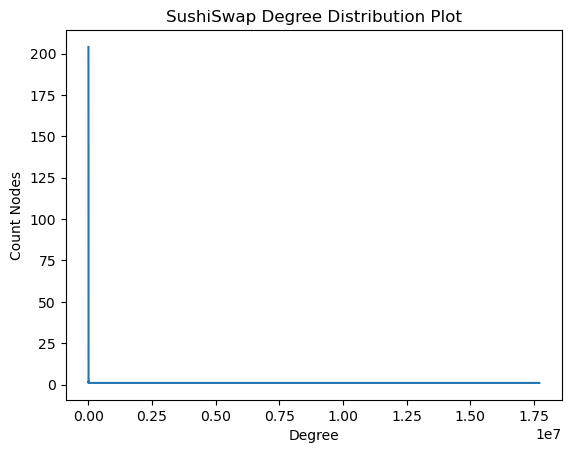

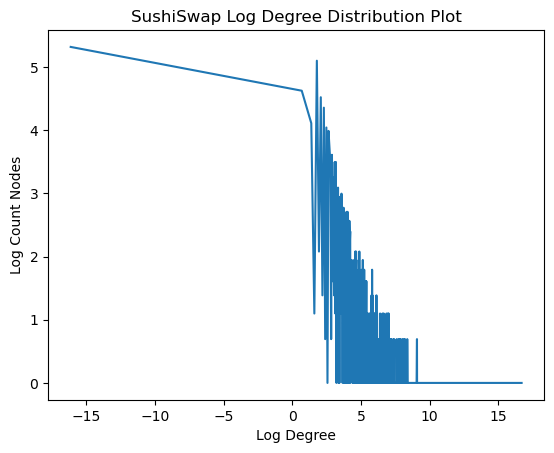

In [47]:
degree_list = dict(sushi_graph.crypto_graph.degree(weight = 'weight'))
degree_list = sushi_graph.get_reversed_sorted_ranks(degree_list)
degree_list = sushi_graph.change_ranks_with_symbol(degree_list)
degree_list = [x[1] for x in degree_list]
count_degree = sushi_graph.get_count_deg(degree_list)
# count_degree = [(x[1], x[0]) for x in count_degree]
sushi_graph.plot_degree(count_degree)
sushi_graph.plot_log_degree(count_degree)